# Modeling

In [1]:
#INSTALLING DEPENDENCIES
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Input, Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from keras.optimizers import Adam
from keras import regularizers

## Loading Preprocessed Data 

In [2]:
# file for data from 2018-2021 : Kelmarsh_turbine1(2018-2021).csv
# file for 2020 data Kelmarsh_turbine1-2020.csv

#reading the clean data
PreprocessedDataTurbine1 = pd.read_csv("Kelmarsh_turbine1(2018-2021).csv", sep=',')
PreprocessedDataTurbine1 = PreprocessedDataTurbine1.drop('Unnamed: 0', axis=1)

PreprocessedDataTurbine1.head()

,Wind speed (m/s),Long Term Wind (m/s),Wind speed Sensor 1 (m/s),Wind speed Sensor 2 (m/s),Wind direction (°),Nacelle position (°),Vane position 1+2 (°),Power (kW),Turbine Power setpoint (kW),Reactive power (kvar),...,Blade angle (pitch position) C (°),Yaw bearing angle (°),Gear oil inlet pressure (bar),Gear oil pump pressure (bar),Grid frequency (Hz),Apparent power (kVA),Drive train acceleration (mm/ss),Tower Acceleration X (mm/ss),Tower Acceleration y (mm/ss),anomaly
0,0.742150,-0.609653,0.658625,0.746686,1.588854,1.62371,-0.260758,0.712101,1.021277,-0.736459,...,-0.376718,1.623709,1.114850,0.812539,-0.089257,0.709760,5.487802,0.025632,0.445277,1
1,0.567030,-0.609653,0.513932,0.612426,1.561509,1.62371,-0.311974,0.609483,0.917348,-0.650119,...,-0.376718,1.623709,1.264111,0.955602,-0.052797,0.612785,6.339041,0.002650,0.307569,1
2,0.617562,-0.609653,0.580067,0.627677,1.555763,1.62371,-0.334879,0.700478,1.173613,-0.887011,...,-0.376718,1.623709,0.545394,0.314733,0.107740,0.712037,6.383784,-0.234531,0.052997,1
3,0.607886,-0.609653,0.570906,0.614425,1.549362,1.62371,-0.496544,0.643069,0.978726,-0.718919,...,-0.376718,1.623709,1.824157,1.404832,-0.140324,0.644570,6.049186,-0.202035,0.906125,1
4,0.576726,-0.609653,0.531557,0.519676,1.555541,1.62371,-0.492387,0.451087,0.812603,-0.592508,...,-0.376718,1.623709,0.764606,0.479379,-0.184053,0.456094,6.012873,-0.248266,0.675658,1


In [3]:
PreprocessedDataTurbine1.shape

(166905, 49)

## Splitting the data to train and test data 

### Time Series Split (For LSTM-AE model)

In [4]:
# Assume your data is in a pandas DataFrame named 'df' with a datetime index
split_point = int(.7 * PreprocessedDataTurbine1.shape[0])
train_data = PreprocessedDataTurbine1.loc[PreprocessedDataTurbine1.index < split_point]
test_data = PreprocessedDataTurbine1.loc[PreprocessedDataTurbine1.index >= split_point]

# Split the data into X (features) and y (labels/target)
X_train, y_train = train_data.drop('anomaly', axis=1), train_data['anomaly']
X_test, y_test = test_data.drop('anomaly', axis=1), test_data['anomaly']

# get the indices of the normal points in y_train
normal_idx = y_train[y_train == 0].index
anomaly_idx = y_train[y_train == 1].index

# select only the rows with normal points from X_train to train our unsupervised model
X_train_normal = X_train.loc[normal_idx]
X_train_anomalies = X_train.loc[anomaly_idx]
X_train_normal.shape

train_anomalies = np.count_nonzero(y_train == 1)
test_anomalies = np.count_nonzero(y_test == 1)
print("Size of training data:", y_train.shape)
print("Number of anomalies in training data:", train_anomalies)
print("Size of test data:", y_test.shape)
print("Number of anomalies in test data:", test_anomalies)

Size of training data: (116833,)
Number of anomalies in training data: 35978
Size of test data: (50072,)
Number of anomalies in test data: 9806


### Splitting Row Data 

In [5]:
Rowdata=PreprocessedDataTurbine1

X, y = Rowdata.drop('anomaly', axis=1), Rowdata['anomaly']

# Split the data into training and testing sets
Row_X_train, Row_X_test, Row_y_train, Row_y_test = train_test_split(X, y, test_size=0.3)

Row_train_anomalies = np.count_nonzero(Row_y_train == 1)
Row_test_anomalies = np.count_nonzero(Row_y_test == 1)

print("Size of training data:", Row_y_train.shape)
print("Number of anomalies in training data:", Row_train_anomalies)
print("Size of test data:", Row_y_test.shape)
print("Number of anomalies in test data:", Row_test_anomalies)

Size of training data: (116833,)
Number of anomalies in training data: 32099
Size of test data: (50072,)
Number of anomalies in test data: 13685


## Models

### Random Forest feature selection

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=100)
rfc.fit(Row_X_train, Row_y_train)
rf_y_pred = rfc.predict(Row_X_test)
print(classification_report(Row_y_test, rf_y_pred))

# Create a dictionary that maps feature names to their importances
rf_importances = dict(zip(Row_X_test.columns, rfc.feature_importances_))

# Print the feature importances in descending order
for feature, importance in sorted(rf_importances.items(), key=lambda x: x[1], reverse=True):
    print(f'{feature}: {importance}')

# Select the most important features

### XGBoost (for anomaly location)

In [ ]:
xgb = XGBClassifier()
xgb.fit(Row_X_train, Row_y_train)
xgb_y_pred = xgb.predict(Row_X_test)
print(classification_report(Row_y_test, xgb_y_pred))


# Create a dictionary that maps feature names to their importances
xgb_importances = dict(zip(Row_X_test.columns, xgb.feature_importances_))

# Print the feature importances in descending order
for feature, importance in sorted(xgb_importances.items(), key=lambda x: x[1], reverse=True):
    print(f'{feature}: {importance}')

### AE

In [6]:
# for unsupervised anomaly detection we use only the normal data for training
train_index = Row_y_train[Row_y_train == 0].index
AE_train_data = Row_X_train.loc[train_index]


# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
AE_model = AutoEncoder(output_units=AE_train_data.shape[1])
# configurations of model
AE_model.compile(loss='mae', optimizer='adam')

ae_history = AE_model.fit(
    AE_train_data,
    AE_train_data,
    epochs=60,
    batch_size=256,
    validation_split=0.1
)

Epoch 1/60
298/298 [==============================] - 3s 5ms/step - loss: 0.6407 - val_loss: 0.5653
Epoch 2/60
298/298 [==============================] - 1s 5ms/step - loss: 0.5771 - val_loss: 0.5562
Epoch 3/60
298/298 [==============================] - 1s 5ms/step - loss: 0.5686 - val_loss: 0.5488
Epoch 4/60
298/298 [==============================] - 1s 4ms/step - loss: 0.5631 - val_loss: 0.5452
Epoch 5/60
298/298 [==============================] - 1s 4ms/step - loss: 0.5605 - val_loss: 0.5437
Epoch 6/60
298/298 [==============================] - 1s 4ms/step - loss: 0.5578 - val_loss: 0.5401
Epoch 7/60
298/298 [==============================] - 1s 4ms/step - loss: 0.5545 - val_loss: 0.5363
Epoch 8/60
298/298 [==============================] - 1s 4ms/step - loss: 0.5520 - val_loss: 0.5341
Epoch 9/60
298/298 [==============================] - 1s 5ms/step - loss: 0.5503 - val_loss: 0.5321
Epoch 10/60
298/298 [==============================] - 1s 4ms/step - loss: 0.5485 - val_loss: 0.5304

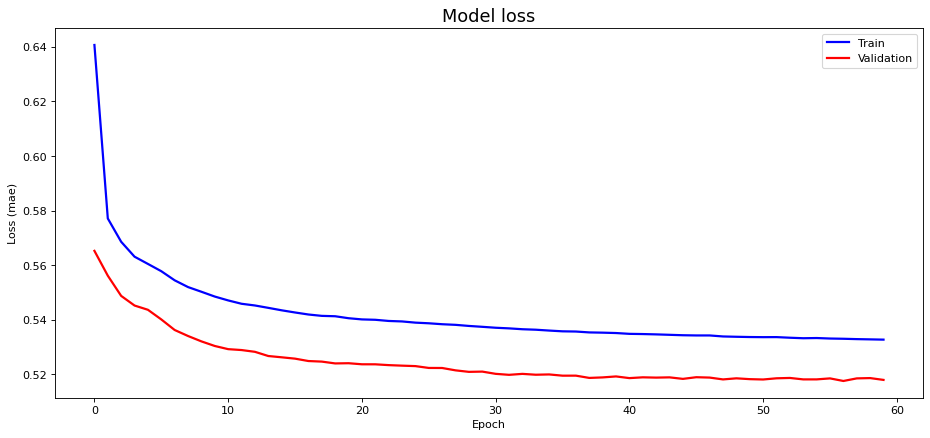

In [7]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(ae_history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(ae_history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

2648/2648 [==============================] - 3s 1ms/step


(0.0, 2.0)

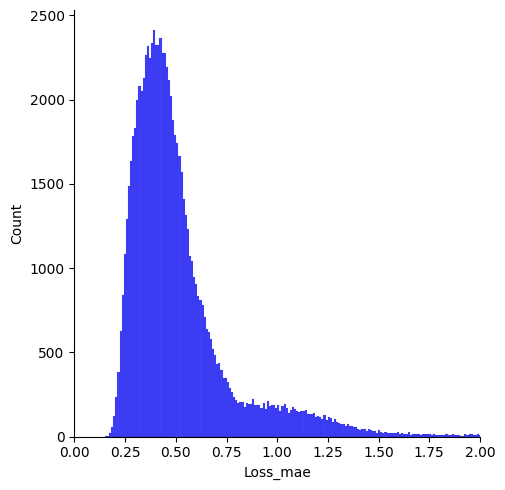

In [11]:
# plot the loss distribution of the training set
ae_X_pred = AE_model.predict(AE_train_data)
ae_X_pred = pd.DataFrame(ae_X_pred, columns=AE_train_data.columns)
ae_X_pred.index = AE_train_data.index

ae_scored = pd.DataFrame(index=AE_train_data.index)
ae_scored['Loss_mae'] = np.mean(np.abs(ae_X_pred-AE_train_data), axis = 1)


sns.displot(ae_scored['Loss_mae'], color = 'blue');
plt.xlim([0.0,2])

In [12]:
# calculate the loss on the test set
ae_X_pred = AE_model.predict(Row_X_test)
ae_X_pred = pd.DataFrame(ae_X_pred, columns=Row_X_test.columns)
ae_X_pred.index = Row_X_test.index
ae_scored = pd.DataFrame(index=Row_X_test.index)
ae_scored['Loss_mae'] = np.mean(np.abs(ae_X_pred-Row_X_test), axis = 1)
ae_scored['Threshold'] = 0.8
ae_scored['Anomaly'] = ae_scored['Loss_mae'] > ae_scored['Threshold']
print(ae_scored.head())

print(ae_scored.loc[ae_scored['Anomaly']==True].shape)
print(Row_y_test.sum())

1565/1565 [==============================] - 2s 1ms/step
        Loss_mae  Threshold  Anomaly
102194  0.375359        0.8    False
55639   0.267196        0.8    False
23079   0.276215        0.8    False
56983   0.506240        0.8    False
84201   0.234355        0.8    False
(6313, 3)
13685


In [13]:
print(ae_scored.loc[ae_scored['Loss_mae'] > ae_scored['Threshold']].shape)

ae_ypred=ae_scored['Anomaly']

# y_test and ypred are the true and predicted labels, respectively
ae_report = classification_report(Row_y_test, ae_ypred)

print(ae_report)

(6313, 3)
              precision    recall  f1-score   support

           0       0.74      0.88      0.80     36387
           1       0.34      0.16      0.21     13685

    accuracy                           0.69     50072
   macro avg       0.54      0.52      0.51     50072
weighted avg       0.63      0.69      0.64     50072



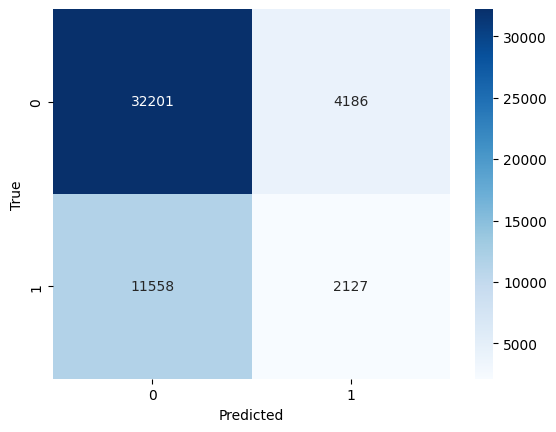

In [14]:
# Compute the confusion matrix
ae_cm = confusion_matrix(Row_y_test, ae_ypred)

# Plot the confusion matrix
sns.heatmap(ae_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### LSTM-AE 

In [15]:
 # reshape inputs for LSTM [samples, timesteps, features]
X_Train = X_train_normal.values
X_Test = X_test.values
n_samples_train = X_Train.shape[0]
n_features = X_Train.shape[1]
n_timesteps = 1
X_Train = X_Train.reshape(n_samples_train, n_timesteps, n_features)
print("Training data shape:", X_Train.shape)
n_samples_test = X_Test.shape[0]
X_Test = X_Test.reshape(n_samples_test, n_timesteps, n_features)
print("Test data shape:", X_Test.shape)

Training data shape: (80855, 1, 48)
Test data shape: (50072, 1, 48)


In [16]:
# define the autoencoder network model
def lstm_autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True,kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [17]:
# create the autoencoder model
lstmae_model = lstm_autoencoder_model(X_Train)
lstmae_model.compile(optimizer='adam', loss='mae')
lstmae_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 48)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             4160      
                                                                 
 lstm_1 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 4)             0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_3 (LSTM)               (None, 1, 16)             1344      
                                                             

In [18]:
# fit the model to the data
nb_epochs = 20
batch_size = 512
lstmae_history = lstmae_model.fit(X_Train, X_Train, epochs=nb_epochs, batch_size=batch_size,validation_split=0.1).history

Epoch 1/20
143/143 [==============================] - 6s 10ms/step - loss: 0.6690 - val_loss: 0.5726
Epoch 2/20
143/143 [==============================] - 1s 5ms/step - loss: 0.5348 - val_loss: 0.4185
Epoch 3/20
143/143 [==============================] - 1s 5ms/step - loss: 0.3871 - val_loss: 0.3297
Epoch 4/20
143/143 [==============================] - 1s 5ms/step - loss: 0.3124 - val_loss: 0.2975
Epoch 5/20
143/143 [==============================] - 1s 5ms/step - loss: 0.2839 - val_loss: 0.2810
Epoch 6/20
143/143 [==============================] - 1s 5ms/step - loss: 0.2671 - val_loss: 0.2728
Epoch 7/20
143/143 [==============================] - 1s 5ms/step - loss: 0.2608 - val_loss: 0.2686
Epoch 8/20
143/143 [==============================] - 1s 5ms/step - loss: 0.2571 - val_loss: 0.2655
Epoch 9/20
143/143 [==============================] - 1s 6ms/step - loss: 0.2543 - val_loss: 0.2629
Epoch 10/20
143/143 [==============================] - 1s 6ms/step - loss: 0.2516 - val_loss: 0.261

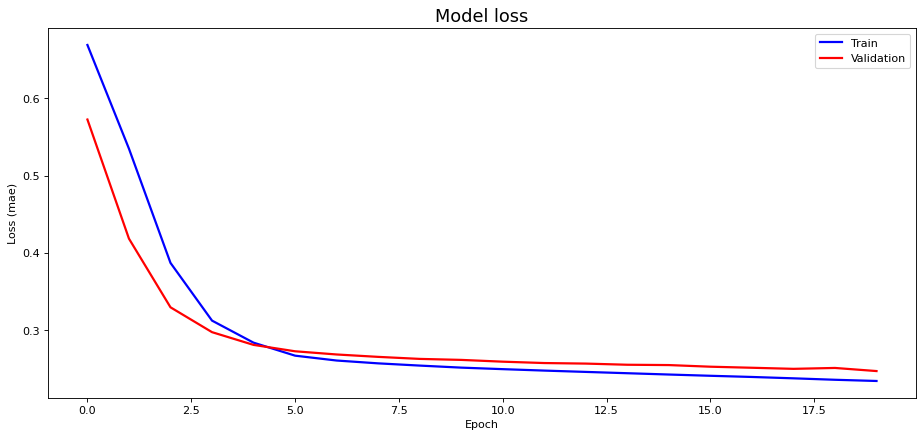

In [19]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(lstmae_history['loss'], 'b', label='Train', linewidth=2)
ax.plot(lstmae_history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

2527/2527 [==============================] - 4s 2ms/step


(0.0, 2.0)

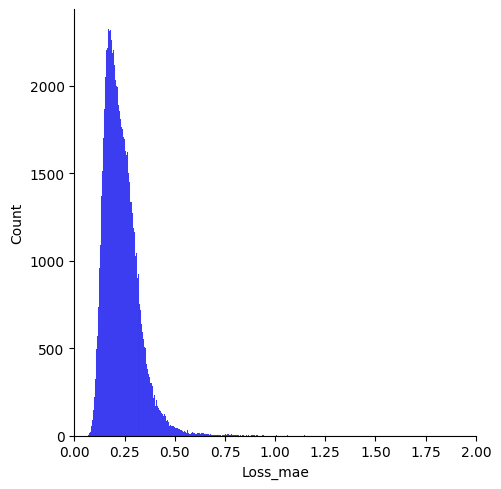

In [22]:
# plot the loss distribution of the training set
lstmae_X_pred = lstmae_model.predict(X_Train)
lstmae_X_pred = lstmae_X_pred.reshape(lstmae_X_pred.shape[0], lstmae_X_pred.shape[2])
lstmae_X_pred = pd.DataFrame(lstmae_X_pred, columns=X_train_normal.columns)
lstmae_X_pred.index = X_train_normal.index

lstmae_scored = pd.DataFrame(index=X_train_normal.index)
Xtrain = X_Train.reshape(X_Train.shape[0], X_Train.shape[2])
lstmae_scored['Loss_mae'] = np.mean(np.abs(lstmae_X_pred-Xtrain), axis = 1)


sns.displot(lstmae_scored['Loss_mae'], color = 'blue');
plt.xlim([0.0,2])

In [25]:
# calculate the loss on the test set
lstmae_X_pred = lstmae_model.predict(X_Test)
lstmae_X_pred = lstmae_X_pred.reshape(lstmae_X_pred.shape[0], lstmae_X_pred.shape[2])
lstmae_X_pred = pd.DataFrame(lstmae_X_pred, columns=X_test.columns)
lstmae_X_pred.index = X_test.index
lstmae_scored = pd.DataFrame(index=X_test.index)
lstmae_Xtest = X_Test.reshape(X_Test.shape[0], X_Test.shape[2])
lstmae_scored['Loss_mae'] = np.mean(np.abs(lstmae_X_pred-lstmae_Xtest), axis = 1)
lstmae_scored['Threshold'] = 0.4
lstmae_scored['Anomaly'] = lstmae_scored['Loss_mae'] > lstmae_scored['Threshold']
lstmae_scored.head()

print(lstmae_scored.loc[lstmae_scored['Anomaly']==True].shape)
print(y_test.sum())


1565/1565 [==============================] - 2s 2ms/step
(2786, 3)
9806


<Axes: >

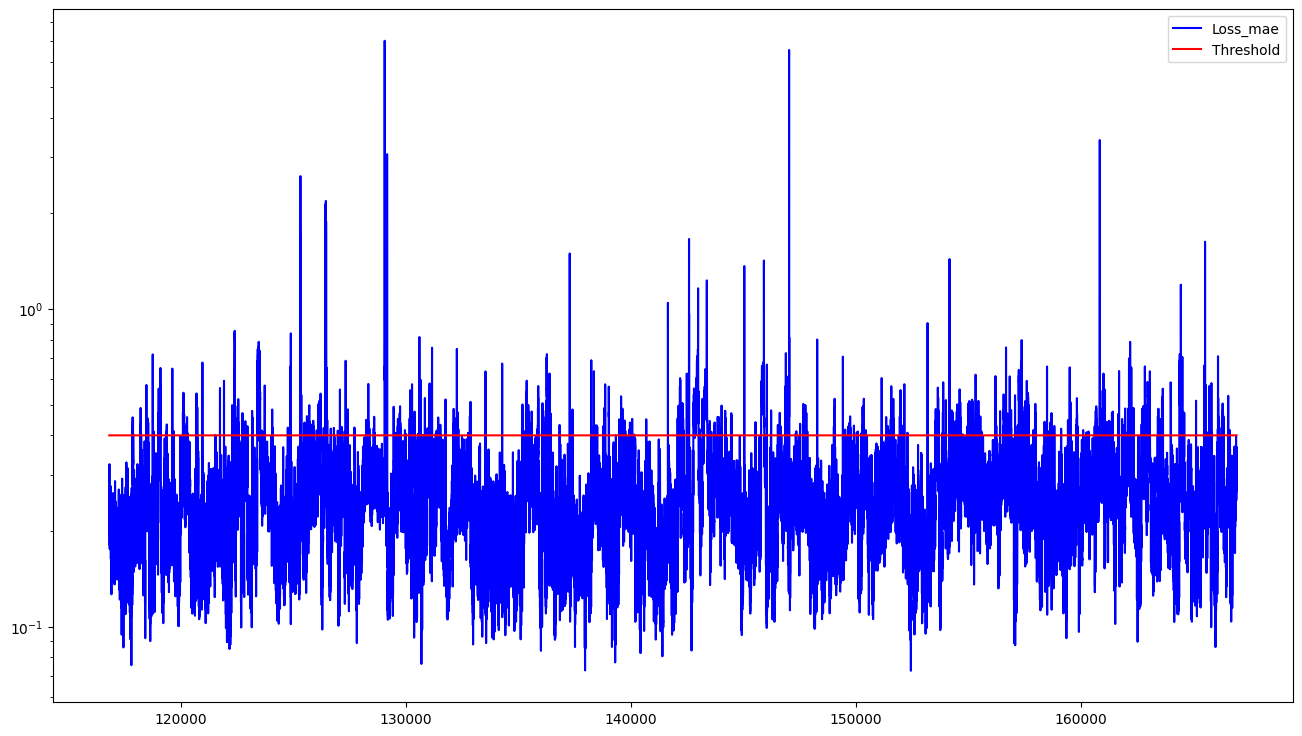

In [26]:
# plot bearing failure time plot
lstmae_scored.plot(logy=True, figsize=(16,9), color=['blue','red'])

In [29]:
print(lstmae_scored.loc[lstmae_scored['Loss_mae'] > lstmae_scored['Threshold']].shape)

lstmae_ypred=lstmae_scored['Anomaly']

# y_test and ypred are the true and predicted labels, respectively
report = classification_report(y_test, lstmae_ypred)

print(report)

(2786, 3)
              precision    recall  f1-score   support

           0       0.81      0.95      0.88     40266
           1       0.30      0.09      0.13      9806

    accuracy                           0.78     50072
   macro avg       0.56      0.52      0.50     50072
weighted avg       0.71      0.78      0.73     50072



### CNN 

In [30]:
# Split the data into X (features) and y (labels/target)
#cnn_X_train, cnn_y_train = train_data.drop('anomaly', axis=1), train_data['anomaly']
#cnn_X_test, cnn_y_test = test_data.drop('anomaly', axis=1), test_data['anomaly']

cnn_X_train = Row_X_train
cnn_y_train = Row_y_train
cnn_X_test = Row_X_test
cnn_y_test = Row_y_test

# Reshape the data for CNN input
cnn_X_train = np.reshape(cnn_X_train.values, (cnn_X_train.shape[0], cnn_X_train.shape[1], 1))
cnn_X_test = np.reshape(cnn_X_test.values, (cnn_X_test.shape[0], cnn_X_test.shape[1], 1))


In [31]:
# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(cnn_X_train.shape[1], cnn_X_train.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(units=1, activation='sigmoid'))

In [32]:
# Compile the model with binary cross-entropy loss and Adam optimizer
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Train the CNN model on the training data
cnn_model.fit(cnn_X_train, cnn_y_train, epochs=100, batch_size=64)

Epoch 1/100


C:\Users\dell\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1826/1826 [==============================] - 8s 4ms/step - loss: 0.5277 - accuracy: 0.7351
Epoch 2/100
1826/1826 [==============================] - 8s 4ms/step - loss: 0.4807 - accuracy: 0.7661
Epoch 3/100
1826/1826 [==============================] - 8s 4ms/step - loss: 0.4531 - accuracy: 0.7865
Epoch 4/100
1826/1826 [==============================] - 10s 6ms/step - loss: 0.4338 - accuracy: 0.7982
Epoch 5/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.4191 - accuracy: 0.8080
Epoch 6/100
1826/1826 [==============================] - 11s 6ms/step - loss: 0.4067 - accuracy: 0.8151
Epoch 7/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.3928 - accuracy: 0.8233
Epoch 8/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.3828 - accuracy: 0.8283
Epoch 9/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.3754 - accuracy: 0.8329
Epoch 10/100
1826/1826 [==============================] - 11s 6ms/step - loss: 

1826/1826 [==============================] - 12s 6ms/step - loss: 0.2286 - accuracy: 0.8998
Epoch 80/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.2284 - accuracy: 0.8998
Epoch 81/100
1826/1826 [==============================] - 11s 6ms/step - loss: 0.2276 - accuracy: 0.8993
Epoch 82/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.2266 - accuracy: 0.9003
Epoch 83/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.2246 - accuracy: 0.9017
Epoch 84/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.2275 - accuracy: 0.9006
Epoch 85/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.2258 - accuracy: 0.9007
Epoch 86/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.2245 - accuracy: 0.9006
Epoch 87/100
1826/1826 [==============================] - 12s 6ms/step - loss: 0.2239 - accuracy: 0.9032
Epoch 88/100
1826/1826 [==============================] - 11s 6ms/st

In [33]:
# Predict the labels of the test data
cnn_y_pred = cnn_model.predict(cnn_X_test)

# Convert the predicted probabilities to class labels
cnn_y_pred = pd.Series(np.ravel(cnn_y_pred))

# Evaluate the model on the testing set
cnn_loss, cnn_accuracy = cnn_model.evaluate(cnn_X_test, cnn_y_test)
print('Testing Accuracy:', cnn_accuracy)

# Convert the predicted probabilities to class labels
cnn_y_pred = pd.Series(np.ravel(cnn_y_pred))
cnn_y_pred = (cnn_y_pred >= 0.4)

# Compute the recall score
cnn_report = classification_report(cnn_y_test,cnn_y_pred)

print('Testing metrics:',cnn_report)

print('Number of test anomalies:',cnn_y_test.sum())
print('Number of predicted anomalies:',cnn_y_pred.sum())

1565/1565 [==============================] - 4s 3ms/step - loss: 0.2196 - accuracy: 0.9147
Testing Accuracy: 0.9146628975868225
Testing metrics:               precision    recall  f1-score   support

           0       0.94      0.94      0.94     36387
           1       0.85      0.84      0.85     13685

    accuracy                           0.92     50072
   macro avg       0.90      0.89      0.89     50072
weighted avg       0.92      0.92      0.92     50072

Number of test anomalies: 13685
Number of predicted anomalies: 13545


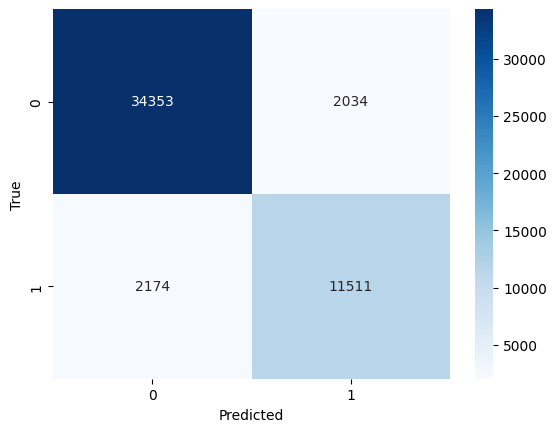

In [34]:
# Compute the confusion matrix
cnn_cm = confusion_matrix(cnn_y_test,cnn_y_pred)

# Plot the confusion matrix
sns.heatmap(cnn_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### ANN

In [35]:
# Build the ANN model
ann_model = Sequential()
ann_model.add(Dense(units=64, activation='relu', input_dim=cnn_X_train.shape[1]))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=32, activation='relu'))
ann_model.add(Dropout(0.2))
ann_model.add(Dense(units=1, activation='sigmoid'))

In [36]:
# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
ann_model.fit(cnn_X_train, cnn_y_train, epochs=100, batch_size=64)

# Evaluate the model on the test set
ann_loss, ann_accuracy = ann_model.evaluate(cnn_X_test, cnn_y_test)
print('Loss:', ann_loss)
print('Accuracy:', ann_accuracy)

Epoch 1/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.5347 - accuracy: 0.7331
Epoch 2/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.4896 - accuracy: 0.7576
Epoch 3/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.4666 - accuracy: 0.7736
Epoch 4/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.4519 - accuracy: 0.7839
Epoch 5/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.4386 - accuracy: 0.7944
Epoch 6/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.4299 - accuracy: 0.8006
Epoch 7/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.4246 - accuracy: 0.8039
Epoch 8/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.4173 - accuracy: 0.8084
Epoch 9/100
1826/1826 [==============================] - 6s 3ms/step - loss: 0.4127 - accuracy: 0.8105
Epoch 10/100
1826/1826 [==============================] - 5s 3ms/step - l

1826/1826 [==============================] - 5s 3ms/step - loss: 0.3372 - accuracy: 0.8540
Epoch 80/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.3365 - accuracy: 0.8538
Epoch 81/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.3354 - accuracy: 0.8537
Epoch 82/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.3375 - accuracy: 0.8536
Epoch 83/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.3372 - accuracy: 0.8545
Epoch 84/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.3339 - accuracy: 0.8564
Epoch 85/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.3363 - accuracy: 0.8555
Epoch 86/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.3352 - accuracy: 0.8550
Epoch 87/100
1826/1826 [==============================] - 5s 3ms/step - loss: 0.3345 - accuracy: 0.8551
Epoch 88/100
1826/1826 [==============================] - 5s 3ms/step - loss:

In [37]:
# Predict the labels of the test data
ann_y_pred = ann_model.predict(cnn_X_test)
# Convert the predicted probabilities to class labels
ann_y_pred = pd.Series(np.ravel(ann_y_pred))
ann_y_pred = (ann_y_pred >= 0.5)

# Compute the recall score
ann_report = classification_report(cnn_y_test,ann_y_pred)

print(ann_report)

1565/1565 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     36387
           1       0.86      0.70      0.77     13685

    accuracy                           0.89     50072
   macro avg       0.88      0.83      0.85     50072
weighted avg       0.89      0.89      0.88     50072



In [38]:
# Predict the labels of the test data
ann_y_pred = ann_model.predict(cnn_X_test)
# Convert the predicted probabilities to class labels
ann_y_pred = pd.Series(np.ravel(ann_y_pred))
ann_y_pred = (ann_y_pred >= 0.5)

# Compute the recall score
ann_report = classification_report(cnn_y_test,ann_y_pred)

print(ann_report)

1565/1565 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     36387
           1       0.86      0.70      0.77     13685

    accuracy                           0.89     50072
   macro avg       0.88      0.83      0.85     50072
weighted avg       0.89      0.89      0.88     50072



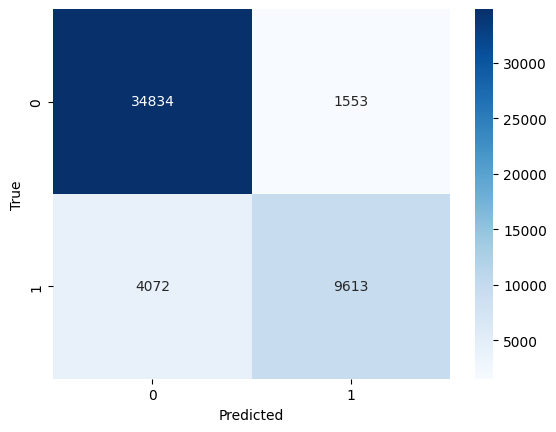

In [39]:
# Compute the confusion matrix
ann_cm = confusion_matrix(cnn_y_test,ann_y_pred)

# Plot the confusion matrix
sns.heatmap(ann_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()